## Analyze dimensionality by computing mutual information x dimensions

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import confusion
from confusion import generate_confusion_matrix
from data_loader import SessionDataLoader
from spikes.filters import gaussian_filter, exp_filter
from spikes.binning import bin_spikes
from template_decoding import (
    compute_distance_to_templates,
    compute_templates,
    decode,
    unbias_templates
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_loader = SessionDataLoader("YelBlu6903F", 1)
table = data_loader.load_table()

In [4]:
t_arr, spikes = bin_spikes(table["spike_times"], min_time=0.0, max_time=0.6)
spikes_filtered = exp_filter(spikes, 5.0)

table["binned_spikes"] = spikes.tolist()
table["psth"] = spikes_filtered.tolist()

In [8]:
unit_table = table[table["unit"] == (2, 2)]

In [51]:
DIMS = [2, 3, 5, 8, 13, 21, 34]

In [53]:
def decode_after_pca(unit_table, template_column="stim", ndim=2):
    pca = PCA(n_components=ndim)
    # save the reduced representation of responses to "resp" column
    unit_table["resp"] = pca.fit_transform(unit_table["psth"].tolist()).tolist()

    templates = compute_templates(unit_table, template_column, "resp")

    if "resp_template" in unit_table: unit_table.drop("resp_template", 1, inplace=True)
    unit_table = unbias_templates(unit_table, templates, template_column, "resp")

    compute_distance_to_templates.clear_cache()
    distances = compute_distance_to_templates(unit_table, template_column, "resp")

    unit_table = unit_table.sort_values(["call_type", "stim"])

    actual = unit_table[template_column]
    predicted = decode(unit_table, distances, template_column)

    return generate_confusion_matrix(actual, predicted, joint=False)

In [55]:
MUTUAL_INFO = []
for dim in DIMS:
    conf = decode_after_pca(unit_table, template_column="stim", ndim=dim)
    mutual_information = confusion.mutual_information(conf)
    print "{:.2f} bits at dim {}".format(mutual_information, dim)
    MUTUAL_INFO.append(mutual_information)

2.75535585426
2.84572676026
3.0420607952
3.21700587984
3.34924588259
3.53571270755


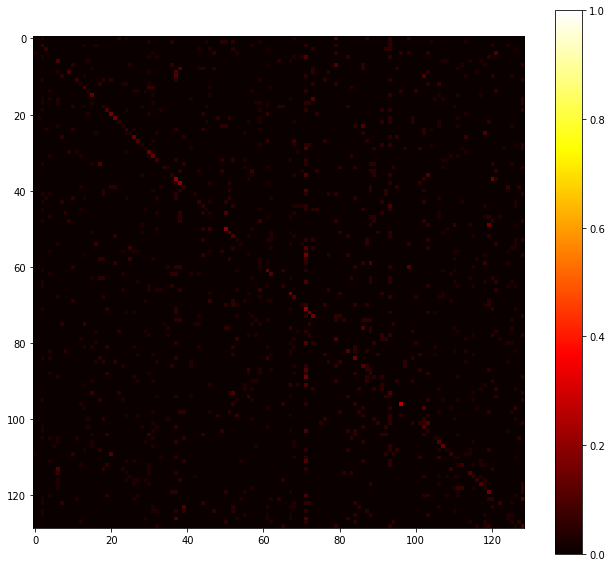

Mutual Information: 3.54 bits
Accuracy: 12.72%


In [56]:
plt.figure(figsize=(11, 10))
plt.imshow(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)

In [92]:
for dim in DIMS:
    unit_table["shuffled_label"] = unit_table["stim"].sample(frac=1).tolist()
    conf = decode_after_pca(unit_table, template_column="shuffled_label", ndim=dim)
    mutual_information = confusion.mutual_information(conf)
    print "{:.2f} bits at dim {}".format(mutual_information, dim)

2.38 bits at dim 2
2.41 bits at dim 3
2.88 bits at dim 5
3.13 bits at dim 8
3.23 bits at dim 13
3.42 bits at dim 21


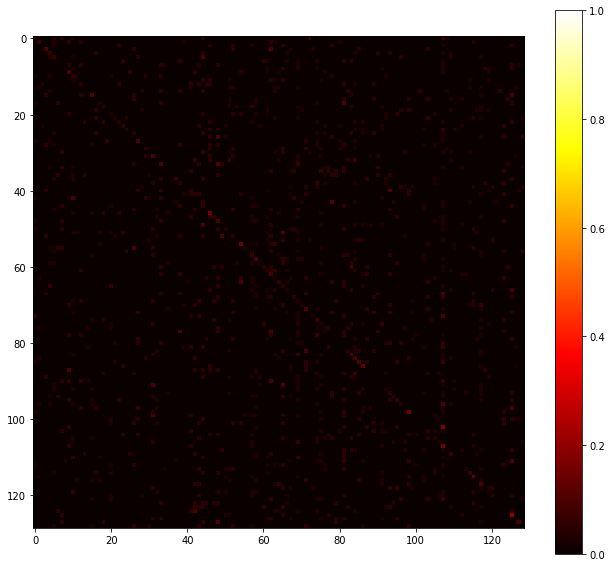

Mutual Information: 3.42 bits
Accuracy: 9.50%


In [93]:
plt.figure(figsize=(11, 10))
plt.imshow(conf, vmin=0.0, vmax=1.0, cmap="hot")
plt.colorbar()
plt.show()
print "Mutual Information: {:.2f} bits".format(confusion.mutual_information(conf))
print "Accuracy: {:.2f}%".format(confusion.accuracy(conf) * 100)